# Predicting Newsletter Subscription from Player Behaviour

**Team 14:** _Caleb · Melki · Kelvin · Mervin_  

In [1]:
### Run this cell before continuing. 
library(tidyverse)
library(tidymodels)
library(themis)
library(repr)

options(repr.matrix.max.rows = 6)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Introduction

The data for this project comes from a research Minecraft server run by a UBC Computer Science group. This server is mainly used to study how people behave in open-world games. We have access to 2 files, but in this report, we are going to only use the file called **players.csv**. This file has one row per player and includes the main account and demographic details. The fields that have been stated describe each player at a very basic level, and they give us enough information to explore the differences between subscribers and non-subscribers.

## Dataset Description

Here are the fields we use to describe each player:

| Variable name | Type | Meaning |
|---------------|------|---------|
| `player_id` | character | Unique ID for each player |
| `subscribed_newsletter` | logical / integer | Whether the player subscribed to the newsletter |
| `played_hours` *(if present)* | numeric | Total hours the player has played |
| `experience` *(if present)* | character | Self-reported experience level |
| `gender` *(if present)* | character | Player gender |
| `Age` *(if present)* | numeric | Player age |
| *(other variables)* | — | Additional account-level information |

*Figure 1*

## Project Question

One of the goals of the research team is to figure out what kind of players are most likely to subscribe to the project’s email newsletter. Since subscribing is optional, it can act as a sign of interest or engagement. If certain patterns in player characteristics predict who subscribes, then the team can make better choices about recruitment and resource planning.

In this report, we focus on the broad question:  
**Which player characteristics help predict whether a player subscribes to the newsletter?**

And more specifically:  
**Can a player's played hours and age predict their likelihood of being subscribed to the newsletter?**


## Approach

To study this question, we use only the variables available in **players.csv**. These include things like total playtime, experience level, age, and gender. We build a single table with one row per player and then explore how these characteristics relate to newsletter subscription. After the exploratory analysis, we fit models to see how well these features can predict whether someone subscribes.

## Method & Results

### 1. Data Reading

Firstly, we read the data with the `read_csv` code, and assign it to `players`.

In [2]:
players <- read_csv("data/players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


*Figure 2*

### 2. Data Cleaning & Wrangling

This data is not ready to be analyzed yet. We need to do cleaning and wrangling to ensure that the data has no `NA` and only consists of the variables we need to answer the proposed question. We use the `drop_na` function to make sure that the columns `Age` and `played_hours` have no `NA` values. After, we use the `select` function to create a table consisting only of `subscribe`, `played_hours`, and `Age`, which we will need for our data analysis. Additionally, we mutate the subscribe variable to a factor so it can be predicted.

In [3]:
players_clean <- players |>
                drop_na(Age, played_hours)|>
                select(subscribe, played_hours, Age) |>
                mutate(subscribe = as.factor(subscribe))

head(players_clean)
tail(players_clean)

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
FALSE,0.0,17
TRUE,0.0,20
TRUE,0.0,17
FALSE,0.3,22
FALSE,0.0,57
FALSE,2.3,17


*Figure 3.1 (top) and Figure 3.2 (under)*

### 3. Data Summary

Next, we create a summary of the data that are relevant for our data analysis. We use the `summarize` function to create a new table with the summary as the variables. We also use the function `round(2)` to round the values to two decimal places to ensure that the values are human readable.


In [4]:
players_summary <- players_clean |> summarize(
    played_hours_mean = mean(played_hours),
    age_mean = mean(Age),
    played_hours_median = median(played_hours),
    total_players = n(),
    subscribe_count = sum(subscribe == "TRUE"),
    subscribe_percentage = subscribe_count / total_players *100)|>
    round(2)

players_summary

played_hours_mean,age_mean,played_hours_median,total_players,subscribe_count,subscribe_percentage
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.9,21.14,0.1,194,142,73.2


*Figure 4*

### 4. Data Visualization

To further understand the trends in the dataset, we will need to create visualizations that might be relevant for the data analysis. First, we use the `options` function to set the size of the visualizations we are going to make. 

The first visualization, `subscribe_age_bar`, explores the distribution of players’ ages and how subscription status varies across these age groups. We use `ggplot` to create a bar plot with age on the x-axis and subscription count on the y-axis. To improve readability, the `Age` variable is grouped into 10-year intervals using `cut_width(Age, width = 10)`. The plot is produced using `geom_bar()`, which is appropriate for displaying the distribution of a numerical variable categorized into bins alongside a factor variable.

The second plot, `subscribe_playedhours_bar`, examines how newsletter subscription relates to players’ total played hours. Similar to the first visualization, we apply `cut_width(played_hours, width = 10)` to group the numeric variable into meaningful intervals, and then use `geom_bar()` to visualize the distribution of subscription across these groups.

The third visualization, `age_time_plot`, investigates the relationship between `Age`, `played_hours`, and `subscribe`. Here, we use `geom_point()` because our primary goal is to explore the relationship between two continuous variables. Coloring the points by subscription status allows us to observe potential differences between subscribed and non-subscribed players within this bivariate relationship.

Across all three visualizations, we use `labs()` and `ggtitle()` to provide clear axis labels and informative titles, ensuring that the plots are interpretable and visually coherent.

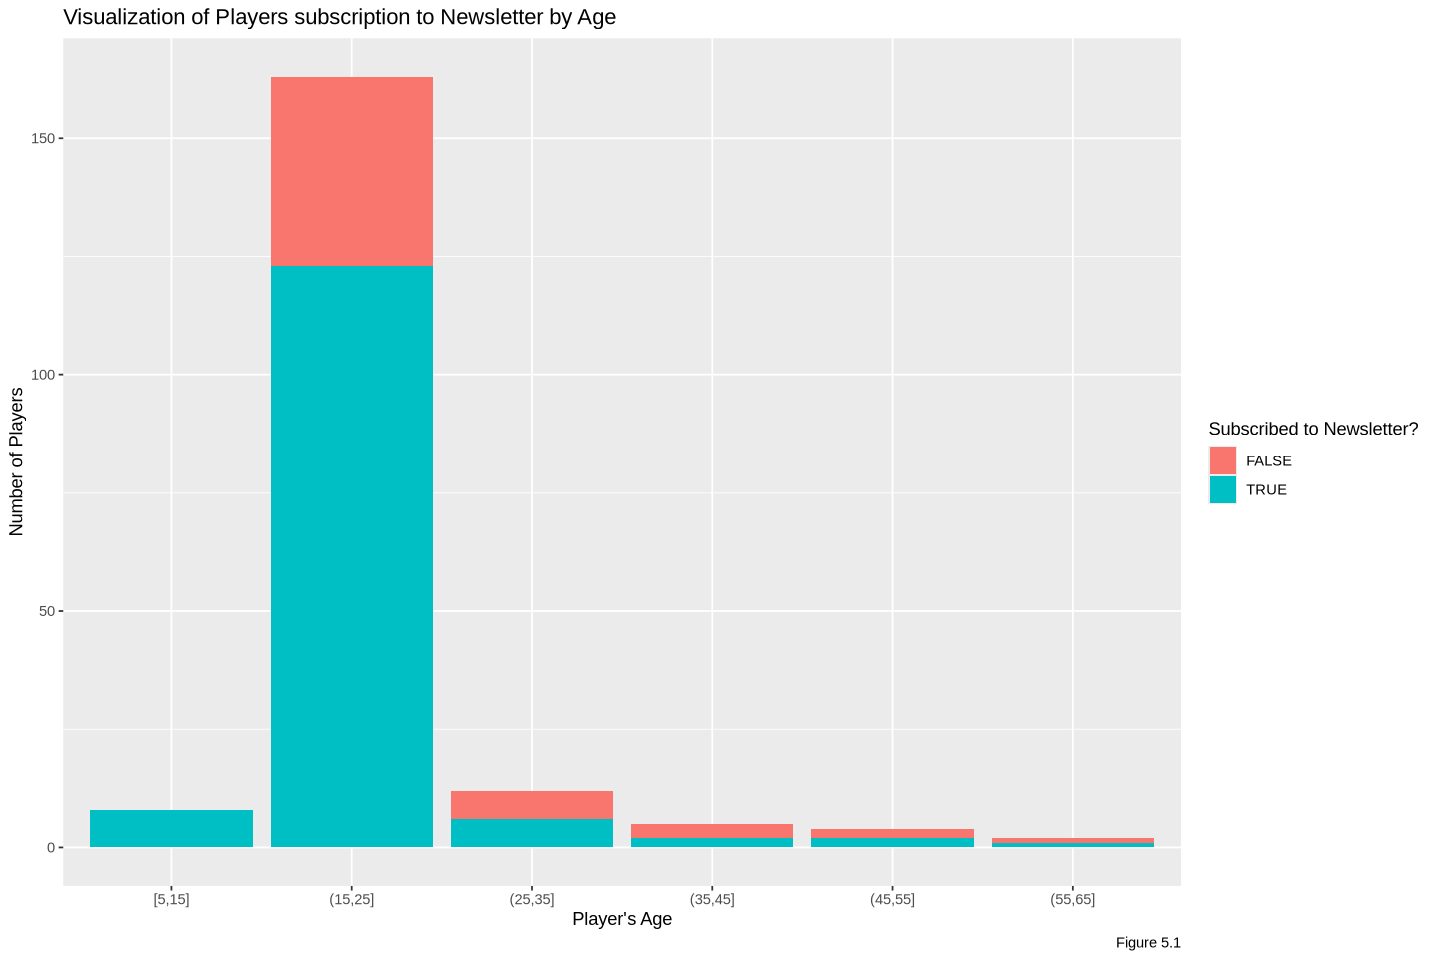

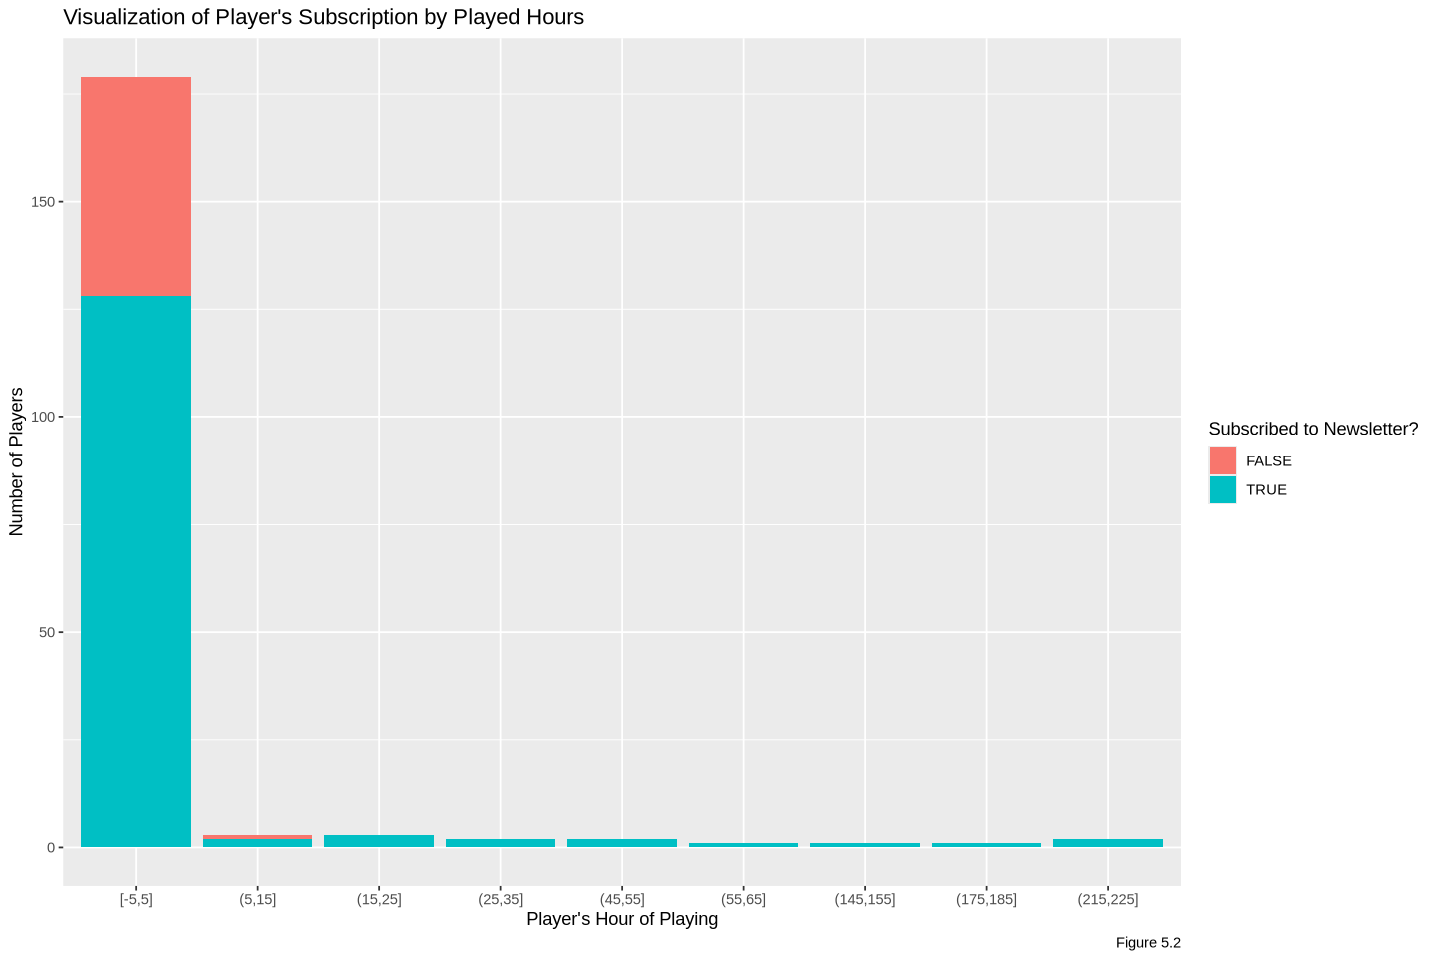

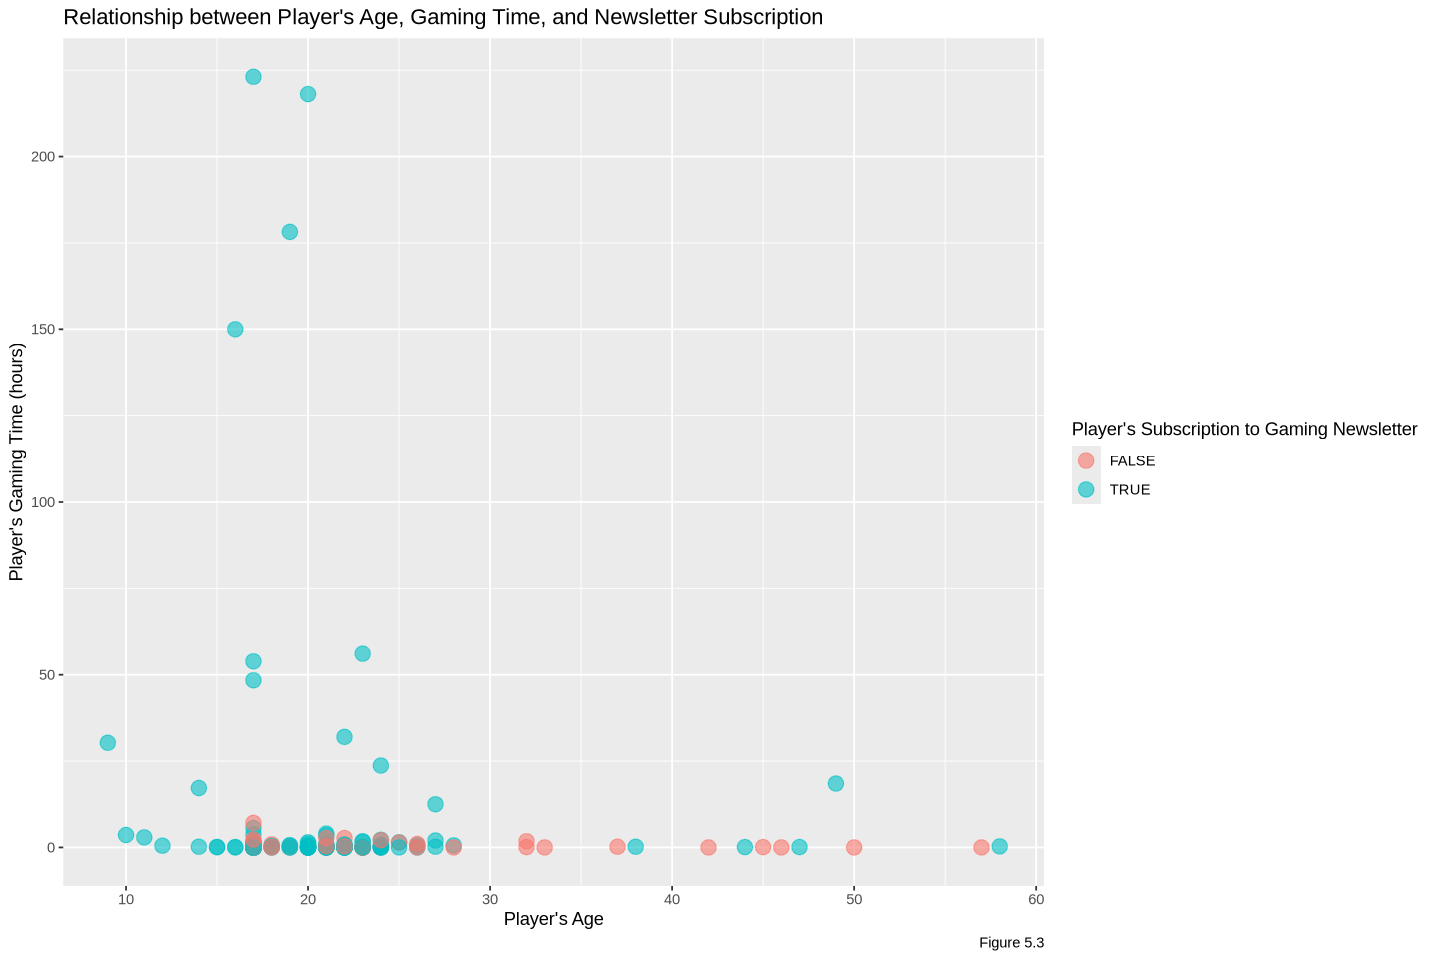

In [17]:
options(repr.plot.width = 12, repr.plot.height = 8) 
subscribe_age_bar <- players_clean|>
            ggplot(aes(fill=subscribe, x = cut_width(Age, width = 10))) +
            geom_bar( )+
            labs(x="Player's Age", y="Number of Players", fill = "Subscribed to Newsletter?")+
            ggtitle("Visualization of Players subscription to Newsletter by Age") +
            labs(caption = "Figure 5.1")
subscribe_age_bar

subscribe_playedhours_bar <- players_clean|>
            ggplot(aes(fill=subscribe, x=cut_width(played_hours, width = 10))) +
            geom_bar()+
            labs(x="Player's Hour of Playing", y="Number of Players", fill = "Subscribed to Newsletter?")+
            ggtitle("Visualization of Player's Subscription by Played Hours") +
            labs(caption = "Figure 5.2")

subscribe_playedhours_bar

options(repr.plot.width = 12, repr.plot.height = 8) 
age_time_plot<- ggplot(players_clean, aes(x= Age, y= played_hours, color=subscribe)) +
            geom_point(size=4, alpha=0.6)+
            labs(x= "Player's Age", y= "Player's Gaming Time (hours)", color= "Player's Subscription to Gaming Newsletter")+
            ggtitle("Relationship between Player's Age, Gaming Time, and Newsletter Subscription") +
            labs(caption = "Figure 5.3")

age_time_plot

### 5. Data Analysis

To perform the data analysis, we create a KNN classification model based on players' ages and total playtime to test whether those 2 variables can predict whether a player subscribed to the newsletter. 

**Splitting the Data**

Before we create the model itself, we need to split the data into a training and a testing set. The variable subscribed is going to be predicted, so it will be stratified. We will use the ``initial_split`` function to split the data into a 75/25 split of the training set (75%) and the testing set (25%). These numbers were chosen to ensure each set has a sufficient number of observations.

In [6]:
set.seed(1)

player_split <- players_clean |> initial_split(prop = 0.75, strata = subscribe)

player_training <- training(player_split)
player_testing <- testing(player_split)

head(player_training)
tail(player_training)

nrow(player_training)
nrow(player_testing)

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
FALSE,0.0,17
FALSE,0.0,22
FALSE,0.1,17
FALSE,0.1,18
FALSE,0.0,33
FALSE,1.4,25


subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,0.8,22
TRUE,32.0,22
TRUE,0.1,44
TRUE,0.0,17
TRUE,0.0,17
TRUE,0.0,17


[1] 145

[1] 49

*Figure 6.1 (top) and Figure 6.2 (under)*

From the code above, we can see that the ``initial_split`` function splits the data into 2 sets. The training set with 145 observations, 75% of the players' dataset, and the testing set with 49 observations, 25% of the players' dataset. These numbers appear to be sufficient for the training and testing purposes, so going forward, we will rely on the training dataset to train our model until the end, where we will test it against the test dataset.

**Creating the Model**

From now on, we will begin creating the actual KNN classification model. It will be done in the following steps:

1. Creating the recipe using ``player_training`` with played_hours and Age as the predictors to predict subscribe while also scaling the predicting variables and balancing the class so there is no bias
2. Creating a specification that uses KNN classification and tuning the k-value for the optimal k
3. Splitting the data into 5 folds for cross-validation
4. Creating the workflow for the model using ``tune_grid`` with the cross-validation
5. Repeating the steps for k-values from 1-50

In [12]:
set.seed(1)

#Creating the recipe
player_recipe <- recipe(subscribe ~ played_hours + Age , data = player_training) |>
                 step_scale(all_predictors()) |>
                 step_center(all_predictors()) |>
                 step_upsample(subscribe, over_ratio = 1, skip = TRUE)

#Creating the spec
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
               set_engine("kknn") |>
               set_mode("classification")

#Creating the folds
player_vfold <- vfold_cv(player_training, v = 5, strata = subscribe)

#k values range 1-50
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

#Creating the workflow
player_fit <- workflow() |>
              add_recipe(player_recipe) |>
              add_model(player_spec) |>
              tune_grid(resamples = player_vfold, grid = k_vals)


**Model Metrics**

To then get the metrics and find the best k-value, we will use ``collect_metrics`` and filter for accuracy for each of the k-values. 

neighbors,mean
<dbl>,<dbl>
1,0.4541872
2,0.4541872
3,0.4134975
⋮,⋮
48,0.5426929
49,0.5560099
50,0.5491133


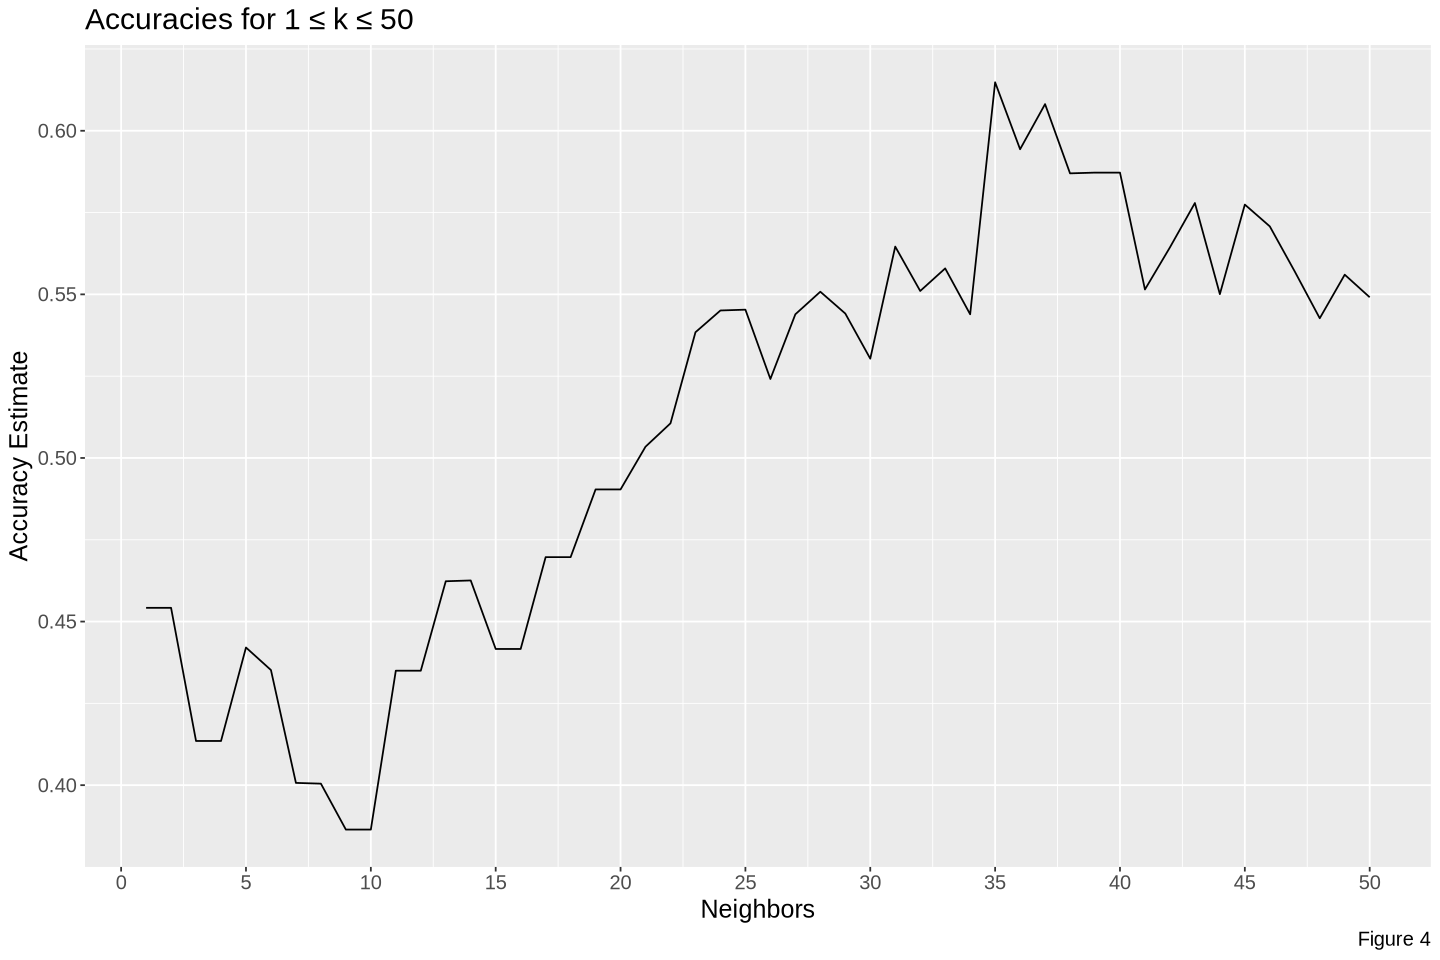

In [13]:
player_fit_metrics <- player_fit |>
                      collect_metrics() |>
                      filter(.metric == "accuracy") |>
                      select(neighbors, mean)

player_fit_metrics

accuracy_versus_k <- ggplot(player_fit_metrics, aes(x = neighbors, y = mean))+
      #geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracies for 1 ≤ k ≤ 50") +
      scale_x_continuous(breaks = seq(0, 50, by = 5)) +
      theme(text = element_text(size = 15)) +
      labs(caption = "Figure 7")

accuracy_versus_k

According to the graph above, we can see the accuracy slowly climbing as the k-value increases. This trend continues until k = 35, where it plateaus. This gives us the value of k = 35 as our k-value with the greatest accuracy.

**The Final Model**

Now that we finally have our desired k-value, we can create the final model and test it. We will use a k of 35 and fit it to ``player_training``.

In [14]:
player_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 35) |>
                     set_engine("kknn") |>
                     set_mode("classification")

player_fit_final <- workflow() |>
                    add_recipe(player_recipe) |>
                    add_model(player_spec_final) |>
                    fit(data = player_training)

player_fit_final

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_scale()
• step_center()
• step_upsample()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(35,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3867925
Best kernel: rectangular
Best k: 35

Above we can see that our workflow was successfully trained and we now have a working model.

**Testing the Model**

Now that we have our working model with the highest accuracy, we can finally test it. We will let the model predict against the ``player_testing`` dataset and create a confusion matrix to analyze the model's performance. 

In [15]:
set.seed(1)

#predict the test dataset
player_predictions <- predict(player_fit_final, player_testing) |>
                      bind_cols(player_testing)

#accuracy of the predictions
model_metrics <- player_predictions |>
                 metrics(truth = subscribe, estimate = .pred_class) |>
                 filter(.metric == "accuracy") 

model_metrics

#confusion matrix, shows the model's weak points

conf_mat <- player_predictions |>
            conf_mat(truth = subscribe, estimate = .pred_class)

conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5306122


          Truth
Prediction FALSE TRUE
     FALSE     9   19
     TRUE      4   17

*Figure 8.1 (top) and Figure 8.2 (under)*